The goal of this notebook is to evaluate the embeddings that we have created. Specifically, we are interested in how well (both qualitative and quantitatively) our embeddings do at matching questions with context in the statement portion of the earnings call transcript. Since we divided the statements portion of each earnings call transcript into chunks of size at most 64 words, this reduces to matching each question with the statement chunk that is most "similar" in terms of some predefined similarity metric (e.g. cosine similarity).

In [16]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch

In [2]:
# Change this to point to your embeddings
FILE_PATH = 'embeddings/siameseBERT_epoch0.pickle'

In [3]:
with open(FILE_PATH, 'rb') as f:
    transcript_embeddings = pickle.load(f)

In [35]:
def cosine_sim(u, v, sparse=False):
    if sparse:
        u = u.toarray().T
        v = v.toarray().T
    u = np.reshape(u, (u.shape[0],))
    v = np.reshape(v, (v.shape[0],))
    return np.dot(u.T, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [36]:
def jaccard_sim(u, v, sparse=False):
    if sparse:
        u = u.toarray().T
        v = v.toarray().T
    return np.sum(np.minimum(u, v)) / np.sum((u + v))

In [37]:
# Define this as you see fit
sim_func = cosine_sim

In [38]:
NUM_SAMPLES = len(transcript_embeddings)

In [39]:
q_to_chunk = []
scores = []
for i in range(NUM_SAMPLES):
    curr = {}
    for q_a_idx in range(len(transcript_embeddings[i][1])):
        if transcript_embeddings[i][1][q_a_idx][1] == 1: continue  # This is an answer
        q_embedding = transcript_embeddings[i][1][q_a_idx][0]
        
        curr_best_score, curr_best_chunk = None, None
        for chunk_idx in range(len(transcript_embeddings[i][0])):
            chunk_embedding = transcript_embeddings[i][0][chunk_idx]
            score = sim_func(q_embedding, chunk_embedding)
            
            if curr_best_score is None or score > curr_best_score:
                curr_best_score = score
                curr_best_chunk = chunk_idx
        scores.append(curr_best_score)
        curr[q_a_idx] = curr_best_chunk
    q_to_chunk.append(curr)

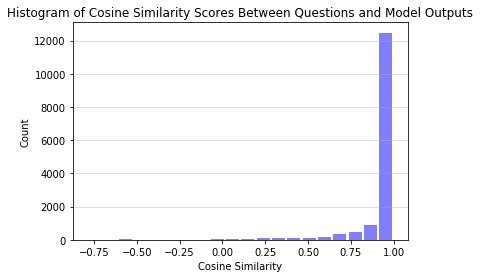

In [40]:
num_bins = 20
n, bins, patches = plt.hist(scores, num_bins, facecolor='blue', alpha=0.5, rwidth=0.85)
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Cosine Similarity')
plt.ylabel('Count') # Adjust if using Jaccard Similarity
plt.title(r'Histogram of Cosine Similarity Scores Between Questions and Model Outputs')
plt.show()

In [11]:
# Now we load the original transcripts (only using the training data for now)
with open('data/transcripts_test.pickle', 'rb') as f:
    transcripts = pickle.load(f)

In [12]:
for i, mapping in enumerate(q_to_chunk):
    for q_idx in mapping.keys():
        print(q_idx)
        print ("QUESTION TEXT:\n")
        print(transcripts[i][3][q_idx][0])
        print("\nANSWER TEXT\n")
        print(transcripts[i][3][q_idx + 1][0])
        print("\nMODEL OUTPUT:\n")
        print(transcripts[i][2][mapping[q_idx]] + '\n')
        print('#' * 75)

0
QUESTION TEXT:

thank first question comes line vivien azer cowen hi good morning

ANSWER TEXT

good morning vivien

MODEL OUTPUT:

committed returning excess free cash shareholders time operator ready first question

###########################################################################
2
QUESTION TEXT:

bai certainly encouraging optimistic outlook 2017 kind circling back conversation november around acquisition informing distribution opportunity seeing pickup velocity particular perhaps super bowl advertising quite good

ANSWER TEXT

vivien marty good morning mean base business performing well still much distribution opportunity larry prepared remarks talked innovation may talked november bubble sparkling version base product everybody view really underrepresented market big push bubbles well new packaging bai black see beginning marketplace essence product traditional csd flavors saw slide sort interesting sort billboard dear soda welcome black really excited taken together c

IndexError: list index out of range